In [30]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [31]:
tf.test.is_gpu_available()

False

In [32]:
vocab_size = 1000
embedding_dim = 128
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [33]:
import pandas as pd
df = pd.read_csv('EP1.csv')

In [34]:
df = df.sample(frac=1)

In [35]:
X = df.prescription.values
y = df.specialty.values

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

In [37]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) #only train
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'hcl': 2,
 'sodium': 3,
 'er': 4,
 'tartrate': 5,
 'metoprolol': 6,
 'potassium': 7,
 'omeprazole': 8,
 'amlodipine': 9,
 'calcium': 10}

In [38]:
len(word_index)

1046

In [39]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [40]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [41]:
encoder = LabelEncoder()
encoder.fit(y)

LabelEncoder()

In [42]:
encoder.inverse_transform([0,1,2,3,4,5,6])

array(['cardiovasculardisease', 'gastroenterology', 'generalpractice',
       'hematologyoncology', 'nephrology', 'neurology', 'psychiatry'],
      dtype=object)

In [43]:
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [44]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[120]))
print('---')
print(X_train[120])

omeprazole ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
omeprazole


In [45]:
y_train[120]

1

In [46]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = 200),
    #tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(7, activation='softmax')
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 424,967
Trainable params: 424,967
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(X_train_padded, y_train, epochs=num_epochs,
                    validation_split=0.1, verbose=1)

Train on 1516 samples, validate on 169 samples
Epoch 1/10
1516/1516 [==============================] - 39s 26ms/sample - loss: 1.4829 - acc: 0.4703 - val_loss: 0.6977 - val_acc: 0.8757
Epoch 2/10
1516/1516 [==============================] - 37s 25ms/sample - loss: 0.3955 - acc: 0.8885 - val_loss: 0.2012 - val_acc: 0.9408
Epoch 3/10
1516/1516 [==============================] - 37s 25ms/sample - loss: 0.2140 - acc: 0.9433 - val_loss: 0.1776 - val_acc: 0.9467
Epoch 4/10
1516/1516 [==============================] - 37s 25ms/sample - loss: 0.1532 - acc: 0.9598 - val_loss: 0.1364 - val_acc: 0.9645
Epoch 5/10
1516/1516 [==============================] - 38s 25ms/sample - loss: 0.1362 - acc: 0.9617 - val_loss: 0.2399 - val_acc: 0.8994
Epoch 6/10
1516/1516 [==============================] - 37s 25ms/sample - loss: 0.1220 - acc: 0.9611 - val_loss: 0.1184 - val_acc: 0.9704
Epoch 7/10
1516/1516 [==============================] - 37s 25ms/sample - loss: 0.0879 - acc: 0.9743 - val_loss: 0.1032 - val

In [48]:
model.evaluate(X_test_padded, y_test)

422/422 [==============================] - 2s 4ms/sample - loss: 0.2236 - acc: 0.9455


[0.22362839808396254, 0.94549763]

In [49]:
y_pred=model.predict_classes(X_test_padded)

In [50]:
from sklearn.metrics import   classification_report, confusion_matrix

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        61
           1       0.91      1.00      0.95        51
           2       0.95      0.98      0.97        59
           3       1.00      0.94      0.97        66
           4       0.92      0.97      0.94        59
           5       0.88      0.93      0.90        54
           6       0.98      0.88      0.93        72

    accuracy                           0.95       422
   macro avg       0.94      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422



In [52]:
confusion_matrix(y_test, y_pred)

array([[58,  0,  0,  0,  2,  1,  0],
       [ 0, 51,  0,  0,  0,  0,  0],
       [ 0,  0, 58,  0,  0,  1,  0],
       [ 0,  2,  1, 62,  1,  0,  0],
       [ 0,  1,  1,  0, 57,  0,  0],
       [ 2,  1,  0,  0,  0, 50,  1],
       [ 0,  1,  1,  0,  2,  5, 63]], dtype=int64)

In [53]:
model.save('LSTMPrescription.h5')

In [54]:
import keras
import h5py
predictor = tf.keras.models.load_model('LSTMPrescription.h5')

In [55]:
y_predict1 = predictor.predict_classes(X_test_padded)
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        61
           1       0.91      1.00      0.95        51
           2       0.95      0.98      0.97        59
           3       1.00      0.94      0.97        66
           4       0.92      0.97      0.94        59
           5       0.88      0.93      0.90        54
           6       0.98      0.88      0.93        72

    accuracy                           0.95       422
   macro avg       0.94      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422



In [56]:
from io import StringIO 
sample1 = StringIO("""prescription;
                    trilyte with flavor packets  gavilyten  lansoprazole  nexium  omeprazole  prevalite  asacol hd  pantoprazole sodium  ursodiol  spironolactone  azathioprine  dicyclomine hcl;
                    levofloxacin  letrozole  tamoxifen citrate  dexamethasone  exemestane  prochlorperazine maleate  warfarin sodium  anastrozole  hydrocodoneacetaminophen  potassium chloride  megestrol acetate  klorcon m  alprazolam  ondansetron hcl;
                    amoxicillin;
                    calcium acetate  bisoprololhydrochlorothiazide  allopurinol  potassium citrate  amlodipine besylate;
    
                    """)

    #keywords labeled as 
    #1. gasternology(labeled as 1) 
    #2. hematologyoncology(labeled as 3) 
    #3. generalpractice(labeled as 2)
    #4. nephrology (labeled as 4)
    #first we need to preprocess the example. Store the input texts to a dataframe and preprocess

predictDF = pd.read_csv(sample1, sep =";")


predictDF

,prescription,Unnamed: 1
0,trilyte with flavor packet...,NaN
1,levofloxacin letrozole t...,NaN
2,amoxicillin,NaN
3,calcium acetate bisoprolo...,NaN


In [57]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SPACE_RE = re.compile(' ')
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = SPACE_RE.sub(' ', text)
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

predictDF['prescription'] = predictDF['prescription'].apply(clean_text)
predictDF

,prescription,Unnamed: 1
0,trilyte with flavor packet...,NaN
1,levofloxacin letrozole t...,NaN
2,amoxicillin,NaN
3,calcium acetate bisoprolo...,NaN


In [58]:
X_sample_seq = tokenizer.texts_to_sequences(predictDF.prescription.values)
X_sample_padded = pad_sequences(X_sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [59]:
y_predict = predictor.predict_classes(X_sample_padded)

In [60]:
y_predict

array([1, 3, 2, 4], dtype=int64)

In [61]:
#4 right 0 wrong

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        61
           1       0.91      1.00      0.95        51
           2       0.95      0.98      0.97        59
           3       1.00      0.94      0.97        66
           4       0.92      0.97      0.94        59
           5       0.88      0.93      0.90        54
           6       0.98      0.88      0.93        72

    accuracy                           0.95       422
   macro avg       0.94      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422



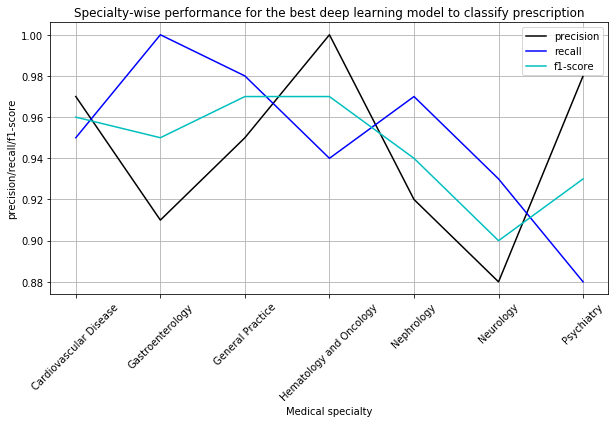

In [65]:
import matplotlib.pyplot as plt
label = ['Cardiovascular Disease', 'Gastroenterology', 'General Practice',
       'Hematology and Oncology', 'Nephrology', 'Neurology', 'Psychiatry']
precision = [ 0.97, 0.91, 0.95, 1.0, 0.92, 0.88, 0.98]
recall = [0.95, 1.0, 0.98, 0.94 ,0.97, 0.93, 0.88]
f1 = [0.96 , 0.95, 0.97, 0.97, 0.94, 0.90, 0.93]
plt.figure(figsize=(10, 5))
plt.xticks([0, 1, 2, 3, 4, 5, 6],label, fontsize=10, rotation=45)
plt.plot(precision, color='k', label = 'precision')
plt.plot(recall, color='b', label = 'recall')
plt.plot( f1, color='c', label = 'f1-score')
plt.legend()
plt.xlabel('Medical specialty')
plt.ylabel('precision/recall/f1-score')
plt.title('Specialty-wise performance for the best deep learning model to classify prescription')
plt.grid()
plt.show()

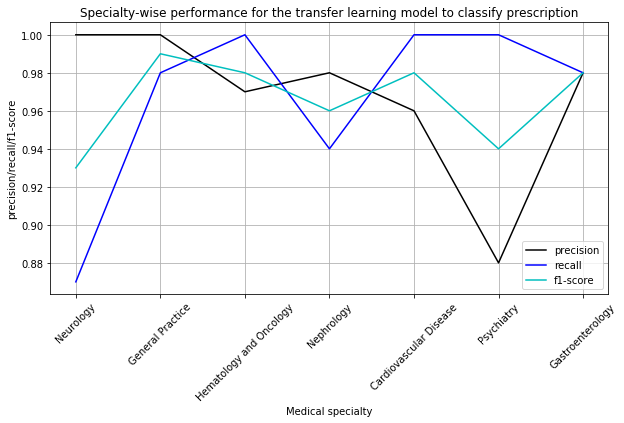

In [66]:
#transfer learning
label = ['Neurology', 'General Practice', 'Hematology and Oncology', 'Nephrology', 'Cardiovascular Disease', 
          'Psychiatry', 'Gastroenterology']
precision = [1.0, 1.0, 0.97, 0.98, 0.96, 0.88, 0.98]
recall = [0.87, 0.98, 1.0, 0.94 ,1.0, 1.0, 0.98]
f1 = [0.93 , 0.99, 0.98, 0.96, 0.98, 0.94, 0.98]
plt.figure(figsize=(10, 5))
plt.xticks([0, 1, 2, 3, 4, 5, 6],label, fontsize=10, rotation=45)
plt.plot(precision, color='k', label = 'precision')
plt.plot(recall, color='b', label = 'recall')
plt.plot( f1, color='c', label = 'f1-score')
plt.legend()
plt.xlabel('Medical specialty')
plt.ylabel('precision/recall/f1-score')
plt.title('Specialty-wise performance for the transfer learning model to classify prescription')
plt.grid()
plt.show()